In [1]:
import gradio as gr
from PIL import Image
import torch
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from captum.attr import IntegratedGradients, GradientShap, Occlusion, NoiseTunnel
from captum.attr import visualization as viz

## Get Dataset Statistics

In [2]:
from utils.preprocessing import get_mean_std, get_label_map

mean, std = get_mean_std('dataset_1500')
label_map = get_label_map('dataset_1500')

Calculating mean and std: 100%|██████████| 141/141 [00:12<00:00, 11.15it/s]


## Image Preprocessing

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

def process_image(image):
    image = transform(image)
    image = image.unsqueeze(0)
    return image

## Load Model

In [4]:
from models import SimpleCNN

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

model = SimpleCNN(num_classes=len(label_map))
model.load_state_dict(torch.load('ckpts/simple_cnn_best_val_loss.pth', weights_only=True))

model.to(device)
model = model.eval()

device: mps


## Predict Function

In [5]:
def predict(image):
    image = process_image(image)
    with torch.no_grad():
        outputs = model(image.to(device))
        probabilities = F.softmax(outputs, dim=1).cpu().numpy()[0]
        return {label_map[i]: float(probabilities[i]) for i in range(len(label_map))}

## Get Occlusion Image Function

In [ ]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    img = Image.open(buf)
    return img

In [7]:
def get_occlusion_image(image):

    transform_image = process_image(image)
    output = model(transform_image.to(device))
    output = F.softmax(output, dim=1)
    _, pred = torch.max(output, 1)
    pred.squeeze_()

    model.to(device)
    model.eval()
    occlusion = Occlusion(model)

    attributions_occ = occlusion.attribute(transform_image.to(device),
                                        strides = (3, 8, 8),
                                        target=pred,
                                        sliding_window_shapes=(3, 15, 15),
                                        baselines=0)

    figure, ax = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        np.array(image),
                                        ["original_image", "heat_map"],
                                        ["all", "positive"],
                                        show_colorbar=True,
                                        outlier_perc=2)

    captum_image = fig2img(figure)
    return captum_image

## Clear Image Function

In [8]:
def clear_image():
    return None, None, None

## App

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://4d7e7335459bdf1b15.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


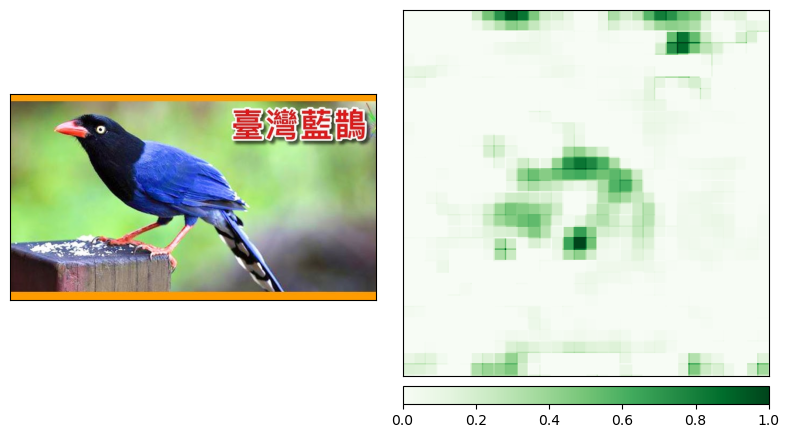

/opt/anaconda3/envs/bmr3/lib/python3.10/site-packages/captum/attr/_utils/visualization.py:443: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/opt/anaconda3/envs/bmr3/lib/python3.10/site-packages/captum/attr/_utils/visualization.py:443: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/opt/anaconda3/envs/bmr3/lib/python3.10/site-packages/captum/attr/_utils/visualization.py:443: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/opt/anaconda3/envs/bmr3/lib/python3.10/site-packages/captum/attr/_utils/visualization.py:443: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/opt/anaconda3/envs/bmr3/lib/python3.10/site-packages/captum/attr/_utils/visualization.py:443: UserWarning: Matplotlib is currently using agg, which is a no

In [ ]:
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="UPLOAD IMAGE")
            clear_button = gr.Button("CLEAR IMAGE")
            upload_button = gr.Button("UPLOAD IMAGE")
        with gr.Column():
            predict_output = gr.Label(num_top_classes=3, label="PREDICTION")
            captum_output = gr.Image(type="pil", label="CAPTUM HEATMAP")
    
    upload_button.click(predict, inputs=image_input, outputs=predict_output)
    upload_button.click(get_occlusion_image, inputs=image_input, outputs=captum_output)

    clear_button.click(clear_image, inputs=[], outputs=[image_input, predict_output, captum_output])

demo.launch(share=True)
